In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor
import joblib
import pickle
import optuna

c:\Users\tomas\Documents\House-Price-Prediction-App_local\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../Data/Real_Estate_Model.csv')

In [4]:
df['state'] = df['state'].astype('category')
df['city'] = df['city'].astype('category')

In [5]:
df.dtypes

status              object
price              float64
bed                  int64
bath                 int64
city              category
state             category
zip_code           float64
house_size         float64
Price_per_sqft     float64
dtype: object

In [7]:
categorical_features = ['state', 'city']
X = df[['bed', 'bath', 'state', 'city', 'house_size']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(
    objective='regression_l1',
    boosting_type='gbdt',
    learning_rate=0.05,
    verbose=1,
    random_state=42,
    eval_metric='mape',
    categorical_features=categorical_features, 
)

base_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    )

base_predictions = base_model.predict(X_test)

base_mape = mean_absolute_percentage_error(y_test, base_predictions)

print(base_mape)


c:\Users\tomas\Documents\House-Price-Prediction-App_local\venv\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
c:\Users\tomas\Documents\House-Price-Prediction-App_local\venv\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] categorical_feature is set with categorical_column=2,3, categorical_features=state,city will be ignored. Current value: categorical_feature=2,3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7268
[LightGBM] [Info] Number of data points in the train set: 1146051, number of used features: 5
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Start training from score 349900.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
0.29565728258480817


In [ ]:
def objective(trial):
    """This function is what Optuna will try to minimize."""
    #Parameters to tune
    params = {
        'objective': 'regression_l1',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularization
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1 
    }
    #Create the model
    model = LGBMRegressor(**params)
    #Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mape',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    #Evaluation of the model
    preds = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)

    return mape

#Objective is to minimize MAPE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


# --- 4. Get the Best Results and Train Final Model ---
print("\nOptuna study finished.")
print("Best trial:")
best_trial = study.best_trial

print(f"  Value (Best MAPE during tuning): {best_trial.value:.4f}")
print("  Best Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#Best parameters from the study
best_params = best_trial.params

#Add back the fixed parameters needed for the final model
best_params['objective'] = 'regression_l1'
best_params['metric'] = 'mape'
best_params['boosting_type'] = 'gbdt'
best_params['random_state'] = 42
best_params['verbose'] = -1
best_params['n_jobs'] = -1

#Train the final model with the best parameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

#Calculate all performance metrics
mae_best = mean_absolute_error(y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(y_test, best_pred))
mape_best = mean_absolute_percentage_error(y_test, best_pred) # Sklearn's MAPE is preferred
r2_best = r2_score(y_test, best_pred)

print("\n--- Final Best Model Performance on Test Set ---")
print(f"MAE: {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAPE: {mape_best:.4f}") # This will be very close to the 'Best trial Value'
print(f"R2 Score: {r2_best:.4f}")
print("------------------------------------------------")

# Save the final, tuned model for your Streamlit app
# with open('tuned_lgbm_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)
joblib.dump(best_model, 'tuned_lgbm_model.pkl', compress = True)

print("\nFinal model trained, evaluated, and saved as 'tuned_lgbm_model.pkl'")


[I 2025-06-01 11:22:46,328] A new study created in memory with name: no-name-73d4833a-798b-4696-b442-63e45b131d20
[I 2025-06-01 11:23:58,270] Trial 0 finished with value: 0.24448703333943445 and parameters: {'n_estimators': 1231, 'learning_rate': 0.24325323525905887, 'num_leaves': 48, 'max_depth': 15, 'min_child_samples': 59, 'subsample': 0.9858702343900108, 'colsample_bytree': 0.7708928577088179, 'reg_alpha': 0.024410574663249775, 'reg_lambda': 3.2677033053893015e-07}. Best is trial 0 with value: 0.24448703333943445.
[I 2025-06-01 11:25:17,264] Trial 1 finished with value: 0.26210584633281847 and parameters: {'n_estimators': 2174, 'learning_rate': 0.24109468211028828, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 63, 'subsample': 0.6057581664384972, 'colsample_bytree': 0.6526587978245426, 'reg_alpha': 0.0002921109174872534, 'reg_lambda': 0.00010231804717357034}. Best is trial 0 with value: 0.24448703333943445.
[I 2025-06-01 11:26:56,324] Trial 2 finished with value: 0.2430985

Performance by price segment

In [8]:
bins = [0, 300_000, 400_000, 500_000, 1_000_000, float('inf')]
labels = ['<300k', '300k-400k', '400k-500k', '500k-1M', '1M+']

price_segments = pd.cut(y_test, bins=bins, labels=labels)
segment_df = pd.DataFrame({'actual': y_test, 'pred': best_pred, 'segment': price_segments})
segment_df['pct_error'] = np.abs(segment_df['actual'] - segment_df['pred']) / segment_df['actual'] * 100

mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()
print(mape_by_segment)

segment
<300k        35.216622
300k-400k    15.646312
400k-500k    15.309972
500k-1M      16.850587
1M+                NaN
Name: pct_error, dtype: float64


C:\Users\tomas\AppData\Local\Temp\ipykernel_36516\3658000176.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()


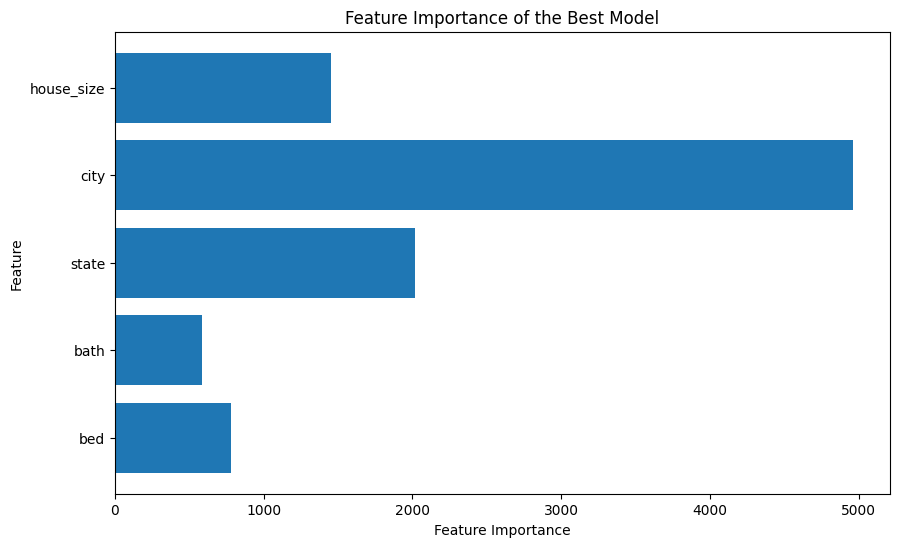

In [8]:
best_feature_importance = best_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, best_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

Low model

In [ ]:
df_low = df[df['price'] < 300000].copy()
X_low = df_low[['bed', 'bath', 'house_size', 'city', 'state']]
y_low = df_low['price']
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size = 0.2, random_state = 42)
# --- 1. Define the Objective Function ---
def objective(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mape', 'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42, 'verbose': -1, 'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    # IMPORTANT: Use the new _low datasets for fitting
    model.fit(
        X_train_low, y_train_low,
        eval_set=[(X_test_low, y_test_low)],
        eval_metric='mape',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    
    # IMPORTANT: Use the new _low test set for evaluation
    preds = model.predict(X_test_low)
    mape = mean_absolute_percentage_error(y_test_low, preds)
    
    return mape

# --- 2. Run the Optuna Study ---
study_low = optuna.create_study(direction='minimize')
study_low.optimize(objective, n_trials=50)

# --- 3. Get Best Results, Evaluate, and Save the Final Model ---
print("\nOptuna study for LOW-PRICE model finished.")
best_trial_low = study_low.best_trial
best_params_low = best_trial_low.params
# Add fixed params
best_params_low.update({'objective': 'regression_l1', 'metric': 'mape', 'random_state': 42, 'verbose': -1, 'n_jobs': -1})

final_model_low = lgb.LGBMRegressor(**best_params_low)
final_model_low.fit(X_train_low, y_train_low)

# Evaluate the final model for the low-price segment
preds_low = final_model_low.predict(X_test_low)
mae_low = mean_absolute_error(y_test_low, preds_low)
rmse_low = np.sqrt(mean_squared_error(y_test_low, preds_low))
mape_low = mean_absolute_percentage_error(y_test_low, preds_low)
r2_low = r2_score(y_test_low, preds_low)

print("\n--- Final LOW-PRICE Model Performance on Test Set ---")
print(f"MAE: {mae_low:.4f}")
print(f"RMSE: {rmse_low:.4f}")
print(f"MAPE: {mape_low:.4f}")
print(f"R2 Score: {r2_low:.4f}")
print("-----------------------------------------------------")

# # IMPORTANT: Save the model with a new, descriptive name
# with open('tuned_lgbm_model_below_300k.pkl', 'wb') as f:
#     pickle.dump(final_model_low, f)
joblib.dump(final_model_low, 'tuned_lgbm_model_below_300k.pkl', compress=True)

print("\nFinal LOW-PRICE model trained, evaluated, and saved as 'tuned_lgbm_model_below_300k.pkl'")


[I 2025-05-26 21:17:16,931] A new study created in memory with name: no-name-5ad6fe82-c60b-4936-b22d-05566d6885f1
[I 2025-05-26 21:17:38,415] Trial 0 finished with value: 0.25540167073110787 and parameters: {'n_estimators': 1146, 'learning_rate': 0.21026113991778536, 'num_leaves': 239, 'max_depth': 6, 'min_child_samples': 47, 'subsample': 0.6415451068272081, 'colsample_bytree': 0.9627988886877299, 'reg_alpha': 8.332230527252972e-05, 'reg_lambda': 0.18594659886925796}. Best is trial 0 with value: 0.25540167073110787.
[I 2025-05-26 21:18:11,986] Trial 1 finished with value: 0.25212584754357154 and parameters: {'n_estimators': 1455, 'learning_rate': 0.20084447123156118, 'num_leaves': 216, 'max_depth': 12, 'min_child_samples': 68, 'subsample': 0.9995724241180097, 'colsample_bytree': 0.6281477794488144, 'reg_alpha': 1.3904746283840782e-08, 'reg_lambda': 3.059455418246815e-08}. Best is trial 1 with value: 0.25212584754357154.
[I 2025-05-26 21:18:23,674] Trial 2 finished with value: 0.2712764


Optuna study for LOW-PRICE model finished.

--- Final LOW-PRICE Model Performance on Test Set ---
MAE: 36976.2899
RMSE: 48818.3446
MAPE: 0.2490
R2 Score: 0.4762
-----------------------------------------------------

Final LOW-PRICE model trained, evaluated, and saved as 'tuned_lgbm_model_below_300k.pkl'


Implementing a two-model strategy proved highly effective. A dedicated model for the sub-$300k housing segment successfully decreased its prediction error (MAPE) from 35% to 24.9%.